In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from id01lib import id01h5
from id01lib.xrd.qconversion import scan_to_qspace_h5,qconvert_mgrid
from id01lib.xrd.geometries import ID01psic
from mayavi import mlab

%gui qt5

/users/zatterin/Envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def qconvert_e16018(scan_no, nbins, cen_pix=[216.941,263.187], det_distance=0.723):

    # Sample and scans
    fname = '/users/zatterin/Documents/beam/20170712_HC2912/data/20161114_E16088.h5'
    sample = 'e16088'

    # Experimental parameters
    nrj=8
    print('WARNING: cen_pix={0}, det_distance={1}'.format(cen_pix, det_distance))

    # Open the h5 file
    with h5py.File(fname) as h5f:

        # read / set offsets
        scan = h5f['/{0}/{1}.1'.format(sample,scan_no)]
        phi_off = h5f['/{0}/{1}.1/instrument/positioners/phi'.format(sample,scan_no)].value
        rhx_off = h5f['/{0}/{1}.1/instrument/positioners/rhx'.format(sample,scan_no)].value
        rhy_off = h5f['/{0}/{1}.1/instrument/positioners/rhy'.format(sample,scan_no)].value
        nu_off =  h5f['/{0}/{1}.1/instrument/positioners/nu'.format(sample,scan_no)].value
        ID01psic().usemotors = set(('eta', 'phi', 'nu', 'delta'))

        # set to corresponding offsets if needed
#         ID01psic().set_offsets(eta=-4.1001, rhy=0.065, rhx=0, phi=0.809+phi_off, nu=0)
        ID01psic().set_offsets(eta=0, rhy=0, rhx=0, phi=0.6298, nu=0)


        # convert to q space
        qx, qy, qz, gint = scan_to_qspace_h5(scan, 
                                             cen_pix=(cen_pix[1],cen_pix[0]), 
                                             distance=det_distance, 
                                             energy=8,
                                             nbins=nbins)
        
        return qx, qy, qz, gint
    
def mlab_axes_tweak(axes):
    # Tweak the appearance of the axes labels
    axes.property.line_width = 2
    
    axes.label_text_property.font_family = 'arial'
    axes.label_text_property.orientation = 0
    axes.label_text_property.italic = False
    axes.label_text_property.bold = False

    axes.title_text_property.font_family = 'arial'
    
    axes.axes.font_factor = 1
    axes.axes.label_format = '%2.2f'
    axes.axes.corner_offset = 0.02


Current problem: VTK's .x3d exporter (which is called upon by mlab) seems to fail to treat transparency info correctly. See:
* [This](http://fpavogt.github.io/x3d-pathway/index.html) for info on X3D / html implementation (astrophysics)
* And [this](https://github.com/enthought/mayavi/issues/485) issue on GitHub describing a similar problem.

# One peak

In [3]:
mlab.init_notebook(backend='png')
mlab.options.backend = 'simple'

Notebook initialized with png backend.


In [4]:
scan = 31
# qx, qy, qz, gint = qconvert_e16018(scan, (100,100,100))
qx, qy, qz, gint = qconvert_e16018(scan, (-1,-1,-1))
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 4.7)
s = (qxx, qyy, qzz, i)

Selected /e16088/31.1
Offsets used: phi = 0.6298, mu = 0.0, rhy = 0.0, eta = 0.0, nu = 0.0, rhx = 0.0, delta = 0.0, rhz = 0.0, 
Max. number of bins: 174, 176, 217
Using binning: [174, 176, 217]

Gridding with bins: (174, 176, 217)


Make it a little bit nicer, and plot the projections on the sides. One scan at a time is plotted.

In [5]:
i.min(), i.max()

(0.26827546802556207, 4.9682754680255625)

In [6]:
fig = mlab.figure(size=(1240,1240),fgcolor=(0,0,0),bgcolor=(1,1,1))


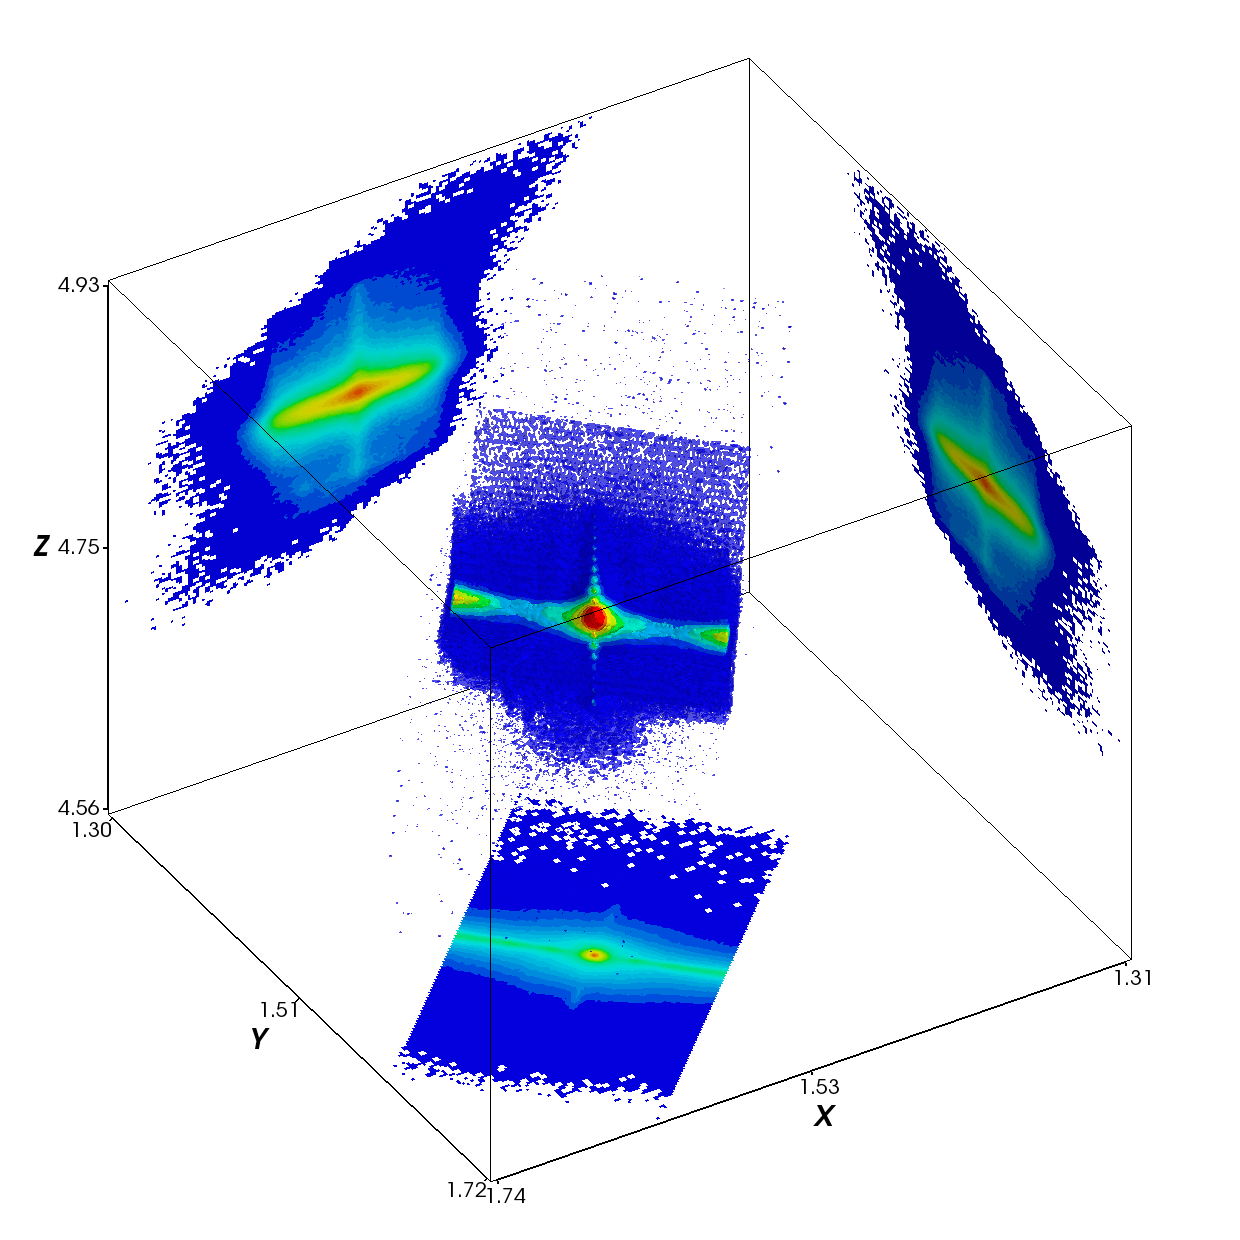

In [7]:
op = 1
t=1e-6
transp = True
yshift = 0.1
xshift = 0.1
zshift = 0.1
projections=True
# make the projections
x,y,z = s[3].sum(0), s[3].sum(1), s[3].sum(2)

# Make a figure
mlab.clf(fig)

# Source the 3D data
surf = mlab.pipeline.scalar_field(*s, figure=fig)

# Plot it 
mlab.pipeline.iso_surface(surf, contours=20, opacity=op, transparent=transp, vmin=2, vmax=4)

if projections:
    # Source the projections
    proj = []
    for img in (x,y,z):
        im = mlab.pipeline.array2d_source(img, figure=fig)
        proj.append(im)

    # Tweak spacing and origin
    origin = surf.origin
    spacing = surf.spacing

    for p in proj: 
        p.origin = origin
    proj[0].spacing = spacing[1], spacing[2], spacing[0]
    proj[1].spacing = spacing[0], spacing[2], spacing[1]
    proj[2].spacing = spacing[0], spacing[1], spacing[2]

    # Threshold them and make the surfaces
    psurf = []
    for p, i in zip(proj, (x,y,z)):
        tresh = mlab.pipeline.threshold(p, low=i.min()+t)
        stresh = mlab.pipeline.surface(tresh)
        stresh.enable_contours = True
        stresh.contour.number_of_contours = 30
        stresh.contour.filled_contours = True
        psurf.append(stresh)

    # Tweak position of projection
    psurf[0].actor.actor.origin = origin
    psurf[1].actor.actor.origin = origin
    psurf[2].actor.actor.origin = origin

    psurf[0].actor.actor.position = [0-xshift,0,0]
    psurf[1].actor.actor.position = [0,0-yshift,0]
    psurf[2].actor.actor.position = [0,0,0-zshift]

    # Tweak orientation of projection
    psurf[1].actor.actor.orientation = [90,0,0]
    psurf[0].actor.actor.orientation = [90,90,0]

# Tweak the axes
qx, qy, qz = s[0][:,0,0], s[1][0,:,0], s[2][0,0,:]

axes = mlab.axes(surf, extent=[qx.min()-xshift, qx.max(), 
                               qy.min()-yshift, qy.max(), 
                               qz.min()-zshift, qz.max()],nb_labels=3)

mlab.outline(extent=[qx.min()-xshift, qx.max(), 
                     qy.min()-yshift, qy.max(), 
                     qz.min()-zshift, qz.max()])
mlab_axes_tweak(axes)
fig.scene.parallel_projection = True
fig.scene.line_smoothing = True
fig.scene.render_window.point_smoothing = True
fig.scene.render_window.line_smoothing = True
fig.scene.render_window.polygon_smoothing = True
fig.scene.render_window.multi_samples = 8 # Try with 4 if you think this is slow
# fig.scene.render_window.aa_frames = 8 # Try with 4 if you think this is slow


mlab.view(azimuth=59)
fig.scene.reset_zoom()
# mlab.colorbar()
# mlab.show()
fig

In [8]:
fig.scene.save_gl2ps('113.pdf')

In [33]:
fig2 = mlab.figure()

In [36]:
i = s[3]
cont = i.min() + 0.01
op=1
sl = 53

# Make a figure
mlab.clf(fig2)
    
# Source the 3D data
surf = mlab.pipeline.scalar_field(*s, figure=fig2)

# Extraxt VOIs
voi = mlab.pipeline.extract_grid(surf)
voi.trait_set(x_min=0.01, x_max=99.9, y_min=0.01, y_max=sl, z_min=0.01, z_max=99.99)

voi2 = mlab.pipeline.extract_grid(surf)
voi2.trait_set(x_min=0.01, x_max=sl, y_min=0.01, y_max=99.9, z_min=0.01, z_max=99.9)

# Threshold the data and put it on cut planes
thr = mlab.pipeline.threshold(surf, low=cont)

cut_plane = mlab.pipeline.scalar_cut_plane(thr, plane_orientation='x_axes')
cut_plane2 = mlab.pipeline.scalar_cut_plane(thr, plane_orientation='y_axes')

for plane in (cut_plane, cut_plane2):
    plane.implicit_plane.widget.enabled = False
    plane.enable_contours = True
    plane.contour.filled_contours = True
    plane.contour.number_of_contours = 30

# Plot
mlab.pipeline.iso_surface(voi, contours=[cont], opacity=op)
mlab.pipeline.iso_surface(voi2, contours=[cont], opacity=op)
    
axes = mlab.axes(surf)
# mlab_axes_tweak(axes)
mlab.show()

In [133]:
fig3 = mlab.figure(size=(1240,1240),fgcolor=(0,0,0),bgcolor=(1,1,1))

In [150]:
# Input
yshift = 0
zshift = 0
lvl = s[3].min()+0.01
sl = 60

mlab.clf(fig3)

# Load the data
src = mlab.pipeline.scalar_field(*s, figure=fig3)

# Display the isosurface
surf = mlab.pipeline.iso_surface(src, contours=[lvl], opacity=0.3, color=(1,1,1))

# mlab.pipeline.image_plane_widget(src, plane_orientation='z_axes', slice_index=70, vmin=i.min(), vmax=3)
tresh = mlab.pipeline.threshold(src, low=lvl)
# stresh = mlab.pipeline.surface(tresh)
# stresh.enable_contours = True
# stresh.contour.number_of_contours = 30
# stresh.contour.filled_contours = True
img = mlab.pipeline.image_plane_widget(src, plane_orientation='z_axes', slice_index=sl, vmin=i.min(), vmax=3.5)
# mlab.pipeline.scalar_cut_plane(tresh, plane_orientation='z_axes')

# Tweak the axes
qx, qy, qz = s[0][:,0,0], s[1][0,:,0], s[2][0,0,:]

axes = mlab.axes(surf, extent=[qx.min(), qx.max(), 
                               qy.min()-yshift, qy.max(), 
                               qz.min()-zshift, qz.max()],nb_labels=3)

mlab.outline(extent=[qx.min(), qx.max(), 
                     qy.min()-yshift, qy.max(), 
                     qz.min()-zshift, qz.max()])

mlab_axes_tweak(axes)

# Tweak viz
fig3.scene.parallel_projection = True
fig3.scene.line_smoothing = True
fig3.scene.reset_zoom()
mlab.view(azimuth=59, distance=1)

fig3
mlab.savefig('001cut_{0}.pdf'.format(sl))

# Two peaks

In [79]:
s = {}
for scan in (34,35):
    qx, qy, qz, gint = qconvert_e16018(scan, (100,100,100))
    if scan==41:
        qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 3)
    else:
        qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 3)
    s[scan] = (qxx, qyy, qzz, i)

Selected /e16088/34.1
Offsets used: delta = 0.0, mu = 0.0, rhz = 0.0, nu = 0.0, rhx = 0.0, eta = 0.0, rhy = 0.0, phi = 45.6298, 
Max. number of bins: 504, 517, 258
Using binning: (100, 100, 100)

Gridding with bins: (100, 100, 100)
Selected /e16088/35.1
Offsets used: delta = 0.0, mu = 0.0, rhz = 0.0, nu = 0.0, rhx = 0.0, eta = 0.0, rhy = 0.0, phi = 45.6298, 
Max. number of bins: 504, 517, 258
Using binning: (100, 100, 100)

Gridding with bins: (100, 100, 100)


Preview it quickly together:

In [80]:
mlab.clf()
# a = np.log(s[43][3])
# b = np.log(s[41][3])

# a[np.isinf(a)] = np.nan
# b[np.isinf(b)] = np.nan

a, b = s[43][3], s[41][3]

test = mlab.contour3d(s[43][0],s[43][1],s[43][2],a, contours=20, opacity=1, transparent=True)
mlab.contour3d(s[41][0],s[41][1],s[41][2],b, contours=20, opacity=1, transparent=True)
mlab.axes()
mlab.show()

KeyError: 43

Make it a little bit nicer, and plot the projections on the sides. One scan at a time is plotted.

In [86]:
s[34][3].min(), s[35][3].min()

(2.342402210795685, 1.9175701097310014)

In [81]:
fig = mlab.figure(size=(1240,1240),fgcolor=(0,0,0),bgcolor=(1,1,1))


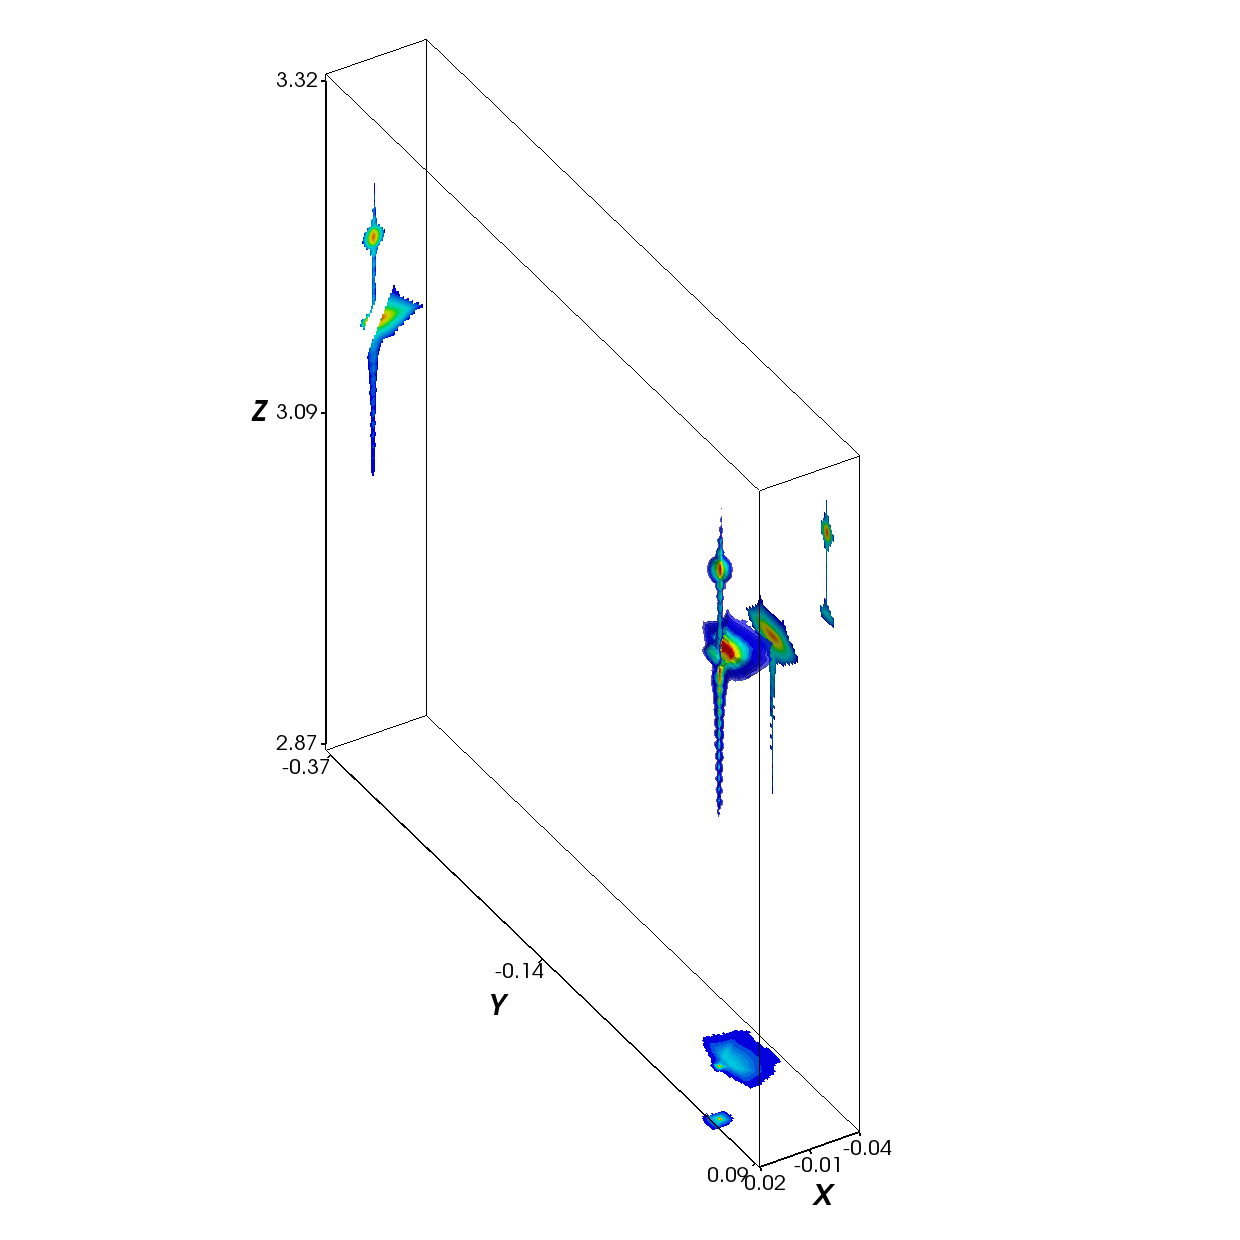

In [88]:
n = 34
n2 = 35

op = 1
t=0.001
transp = True
yshift = 0.3
zshift = 0.1
xshift = 0.0

projections = True

# make the projections
x,y,z = s[n][3].sum(0), s[n][3].sum(1), s[n][3].sum(2)
x2,y2,z2 = s[n2][3].sum(0), s[n2][3].sum(1), s[n2][3].sum(2)
lproj = [x,y,z,x2,y2,z2]

# Make a figure
mlab.clf(fig)

# Source the 3D data
surf = mlab.pipeline.scalar_field(*s[n], figure=fig)
surf2 = mlab.pipeline.scalar_field(*s[n2], figure=fig)

# t = mlab.pipeline.threshold(surf, low=2.8)
# t2 = mlab.pipeline.threshold(surf2, low=2.8)

# Plot it 
mlab.pipeline.iso_surface(surf, contours=20, opacity=op, transparent=transp, vmin=3, vmax=5) 
mlab.pipeline.iso_surface(surf2, contours=20, opacity=op, transparent=transp, vmin=2, vmax=5)

if projections:
    # Source the projections
    proj = []
    for img in lproj:
        im = mlab.pipeline.array2d_source(img, figure=fig)
        proj.append(im)

    # Tweak spacing and origin
    origin = surf.origin
    spacing = surf.spacing
    
    origin2 = surf2.origin
    spacing2 = surf2.spacing

    # Projections of the first surface
    for p in proj[0:3]: 
        p.origin = origin
    proj[0].spacing = spacing[1], spacing[2], spacing[0]
    proj[1].spacing = spacing[0], spacing[2], spacing[1]
    proj[2].spacing = spacing[0], spacing[1], spacing[2]
    
    # Projections of the second surface
    for p in proj[3:6]:
        p.origin = origin2
    proj[3].spacing = spacing2[1], spacing2[2], spacing2[0]
    proj[4].spacing = spacing2[0], spacing2[2], spacing2[1]
    proj[5].spacing = spacing2[0], spacing2[1], spacing2[2]
    
    # Threshold them and make the surfaces
    psurf = []
    for p, i in zip(proj, lproj):
        tresh = mlab.pipeline.threshold(p, low=i.min()+t)
        stresh = mlab.pipeline.surface(tresh)
        stresh.enable_contours = True
        stresh.contour.number_of_contours = 30
        stresh.contour.filled_contours = True
        psurf.append(stresh)
    
    ## First surface
    # Tweak position of projection
    psurf[0].actor.actor.origin = origin
    psurf[1].actor.actor.origin = origin
    psurf[2].actor.actor.origin = origin

    psurf[0].actor.actor.position = [0-xshift,0,0]
    psurf[1].actor.actor.position = [0,0-yshift,0]
    psurf[2].actor.actor.position = [0,0,0-zshift]

    # Tweak orientation of projection
    psurf[1].actor.actor.orientation = [90,0,0]
    psurf[0].actor.actor.orientation = [90,90,0]
    
    ## Second surface
    # Tweak position of projection
    psurf[3].actor.actor.origin = origin2
    psurf[4].actor.actor.origin = origin2
    psurf[5].actor.actor.origin = origin2

    psurf[3].actor.actor.position = [0-0.033,0,0]
    psurf[4].actor.actor.position = [0,0-yshift,0]
    psurf[5].actor.actor.position = [0,0,0-0.25]

    # Tweak orientation of projection
    psurf[4].actor.actor.orientation = [90,0,0]
    psurf[3].actor.actor.orientation = [90,90,0]

# Tweak the axes
qx, qy, qz = s[n2][0][:,0,0], s[n2][1][0,:,0], s[n2][2][0,0,:]
qx2, qy2, qz2 = s[n][0][:,0,0], s[n][1][0,:,0], s[n][2][0,0,:]

axes = mlab.axes(surf, extent=[qx2.min()-xshift, qx.max(), 
                               qy.min()-yshift, qy.max(), 
                               qz2.min()-zshift, qz.max()],nb_labels=3)

mlab.outline(extent=[qx2.min()-xshift, qx.max(), 
                   qy.min()-yshift, qy.max(), 
                   qz2.min()-zshift, qz.max()])

mlab_axes_tweak(axes)

fig.scene.parallel_projection = True
fig.scene.line_smoothing = True
fig.scene.reset_zoom()

mlab.view(azimuth=59,distance=1)
mlab.show()
# mlab.savefig('103.pdf')
fig


Now plot a single isosurface and two cut planes that show the distribution of intensity inside it.

In [9]:
fig2 = mlab.figure()

In [ ]:
n = 41
i = s113[n][3]
cont = i.max()-2.5
op=0.7
z=40

# Make a figure
mlab.clf(fig2)
    
# Source the 3D data
surf = mlab.pipeline.scalar_field(*s113[n], figure=fig2)

# Extraxt VOIs
voi = mlab.pipeline.extract_grid(surf)
voi.trait_set(x_min=0.01, x_max=99.99, y_min=0.01, y_max=99.99, z_min=0.01, z_max=99.99)

voi2 = mlab.pipeline.extract_grid(surf)
voi2.trait_set(x_min=0.01, x_max=99.99, y_min=0.01, y_max=99.99, z_min=0.01, z_max=z)

# Threshold the data and put it on cut planes
thr = mlab.pipeline.threshold(surf, low=cont)

cut_plane = mlab.pipeline.scalar_cut_plane(thr, plane_orientation='z_axes')
cut_plane2 = mlab.pipeline.scalar_cut_plane(thr, plane_orientation='z_axes')

for plane in (cut_plane, cut_plane2):
    plane.implicit_plane.widget.enabled = False
    plane.enable_contours = True
    plane.contour.filled_contours = True
    plane.contour.number_of_contours = 30

# Plot
mlab.pipeline.iso_surface(voi, contours=[cont], opacity=0.1)
mlab.pipeline.iso_surface(voi2, contours=[cont], opacity=1)
    
axes = mlab.axes(surf)
# mlab_axes_tweak(axes)
# mlab.show()

# 113
This is scan **81** of **E16095_furnace.spec**. A threshold of `4.5` should be fine to be visualised in mayavi correctly.

In [12]:
scan = 81
qx, qy, qz, gint = qconvert_e16095(scan, (100,100,100))
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 5.5)
s = (qxx, qyy, qzz, i)

Selected /E16095_furnace/81.1
Offsets used: rhx = 0.656, nu = 0.0, delta = 0.0, rhy = 0.0, rhz = 0.0, phi = 1.994, mu = 0.0, eta = 0.0, 
Max. number of bins: 193, 196, 247
Using binning: (100, 100, 100)

Gridding with bins: (100, 100, 100)


Preview it quickly:

In [13]:
mlab.clf()
mlab.contour3d(*s, contours=20, opacity=.8, transparent=False)
mlab.axes()
mlab.show()

Make it a little bit nicer, and plot the projections on the sides. One scan at a time is plotted.

In [15]:
fig = mlab.figure(size=(1240,1240),fgcolor=(0,0,0),bgcolor=(1,1,1))

In [23]:
op = 1
t=0.001
transp = True
yshift = 0.15
zshift = 0.3
xshift = 0.15

# make the projections
x,y,z = s[3].sum(0), s[3].sum(1), s[3].sum(2)

# Make a figure
mlab.clf(fig)

# Source the 3D data
surf = mlab.pipeline.scalar_field(*s, figure=fig)

# Plot it 
mlab.pipeline.iso_surface(surf, contours=20, opacity=op, transparent=transp)

# Source the projections
proj = []
for img in (x,y,z):
    im = mlab.pipeline.array2d_source(img, figure=fig)
    proj.append(im)

# Tweak spacing and origin
origin = surf.origin
spacing = surf.spacing

for p in proj: 
    p.origin = origin
proj[0].spacing = spacing[1], spacing[2], spacing[0]
proj[1].spacing = spacing[0], spacing[2], spacing[1]
proj[2].spacing = spacing[0], spacing[1], spacing[2]

# Threshold them and make the surfaces
psurf = []
for p, i in zip(proj, (x,y,z)):
    tresh = mlab.pipeline.threshold(p, low=i.min()+t)
    stresh = mlab.pipeline.surface(tresh)
    stresh.enable_contours = True
    stresh.contour.number_of_contours = 30
    stresh.contour.filled_contours = True
    psurf.append(stresh)
    
# Tweak position of projection
psurf[0].actor.actor.origin = origin
psurf[1].actor.actor.origin = origin
psurf[2].actor.actor.origin = origin

psurf[0].actor.actor.position = [0-xshift,0,0]
psurf[1].actor.actor.position = [0,0-yshift,0]
psurf[2].actor.actor.position = [0,0,0-zshift]

# Tweak orientation of projection
psurf[1].actor.actor.orientation = [90,0,0]
psurf[0].actor.actor.orientation = [90,90,0]

# Tweak the axes
qx, qy, qz = s[0][:,0,0], s[1][0,:,0], s[2][0,0,:]

axes = mlab.axes(surf, extent=[qx.min()-xshift, qx.max(), 
                               qy.min()-yshift, qy.max(), 
                               qz.min()-zshift, qz.max()],nb_labels=3)

mlab.outline(extent=[qx.min()-xshift, qx.max(), 
                   qy.min()-yshift, qy.max(), 
                   qz.min()-zshift, qz.max()])

mlab_axes_tweak(axes)

fig.scene.parallel_projection = True
fig.scene.line_smoothing = True
fig.scene.reset_zoom()

mlab.view(azimuth=59,distance=1)

mlab.show()
mlab.savefig('113.pdf')

fig